In [74]:
import IPython
import pandas as pd
import numpy as np
from statistics import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [75]:
df = pd.read_csv('diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [77]:
for col in df.columns:
    if df[col].dtype==object:
        print(col,df[col][df[col]=='?'].count())
print('gender', df['gender'][df['gender']=='Unknown/Invalid'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 3


In [78]:
# Remove slected variables from dataset
columns_to_drop = [
    'weight',
    'medical_specialty',
    'payer_code',
    'citoglipton',
    'examide',
    'change'
]
df = df.drop(columns_to_drop, axis=1)

In [79]:
for col in df.columns:
    if df[col].dtype == object:
        print(col,df[col][df[col]=='?'].count())
print('gender', df['gender'][df['gender']=='Unknown/Invalid'].count())

race 2273
gender 0
age 0
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
diabetesMed 0
readmitted 0
gender 3


In [80]:
df_diagnosis = df.loc[(df['diag_1'] == '?')&
       (df['diag_2'] == '?')&
       (df['diag_3'] == '?')]
df = pd.concat([df,df_diagnosis]).drop_duplicates(keep=False)
df = df.loc[(df['gender'] != 'Unknown/Invalid')]
df = df.loc[(df['race'] != '?')]
df = df.loc[df['discharge_disposition_id'] != 11]

In [81]:
age_groups_mapping = {
    '[0-10)':5,
    '[10-20)':15,
    '[20-30)':25,
    '[30-40)':35,
    '[40-50)':45,
    '[50-60)':55,
    '[60-70)':65,
    '[70-80)':75,
    '[80-90)':85,
    '[90-100)':95
}
df['age'] = df['age'].map(age_groups_mapping)

In [82]:
#### Number of medications changed
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

In [83]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,readmitted,numchange
0,2278392,8222157,Caucasian,Female,5,6,25,1,1,41,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,15,1,1,7,3,59,...,No,Up,No,No,No,No,No,Yes,>30,1
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,11,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,35,1,1,7,2,44,...,No,Up,No,No,No,No,No,Yes,NO,1
4,16680,42519267,Caucasian,Male,45,1,1,7,1,51,...,No,Steady,No,No,No,No,No,Yes,NO,0


In [84]:
df['readmitted'].head()

0     NO
1    >30
2     NO
3     NO
4     NO
Name: readmitted, dtype: object

In [85]:
df.describe()

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,numchange
count,9.788300e+04,9.788300e+04,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000
mean,1.651371e+08,5.454970e+07,65.818835,2.031895,3.621538,5.755065,4.391631,42.919067,1.331825,15.986351,0.373436,0.201853,0.640336,7.426305,0.288314
std,1.024877e+08,3.868310e+07,15.950335,1.451688,5.269959,4.075357,2.976226,19.640346,1.698345,8.084225,1.273442,0.945080,1.270350,1.930843,0.488486
min,1.252200e+04,1.350000e+02,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8.456658e+07,2.344349e+07,55.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.526877e+08,4.598436e+07,65.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,2.297864e+08,8.781311e+07,75.000000,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000
max,4.438672e+08,1.895026e+08,95.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,4.000000


In [86]:
df['numchange'].value_counts()

0    71177
1    25307
2     1288
3      106
4        5
Name: numchange, dtype: int64

In [87]:
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

In [88]:
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

In [89]:
###renaming the categories in the attribute Glucose serum test result
###Norm set to 0 and above 200 & 300 set to 1, Not tested using the "magical -99"
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

In [90]:
df['max_glu_serum'].value_counts()

-99    92712
 1      2622
 0      2549
Name: max_glu_serum, dtype: int64

In [91]:
##### 92712 - not tested--- maybe drop the attribute
### when evaluating a model ---- taking into account not only the Accuracy, but also False Negative & False Positive values, because there is a hidden value in them


In [92]:
### binary classification : No and readmission after more than 30 days set to 0, readmission within 30 days-set to 1
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

In [93]:
df['readmitted'].value_counts()

0    86714
1    11169
Name: readmitted, dtype: int64

In [94]:
#### converting nominal values for race in numeric
df['race']=df['race'].replace('Caucasian',0)
df['race']=df['race'].replace('Asian',1)
df['race']=df['race'].replace('AfricanAmerican',2)
df['race']=df['race'].replace('Hispanic',3)
df['race']=df['race'].replace('Other',4)

In [95]:
df['race'] = pd.to_numeric(df['race'])

In [96]:
df = df.drop([
    'diag_1',
    'diag_2',
    'diag_3',
    'A1Cresult'
], axis=1)

In [97]:
#df.to_csv('data_cleaned.csv')

## Interaction Terms
Correlate all variables with each other

In [98]:
corr_matrix = df.corr().abs()
corr_series = corr_matrix.unstack().sort_values(ascending=False)
corr_series[41:150]

diabetesMed               insulin                     0.581694
patient_nbr               encounter_id                0.514487
encounter_id              patient_nbr                 0.514487
max_glu_serum             admission_source_id         0.475769
admission_source_id       max_glu_serum               0.475769
time_in_hospital          num_medications             0.464353
num_medications           time_in_hospital            0.464353
insulin                   numchange                   0.450367
numchange                 insulin                     0.450367
max_glu_serum             admission_type_id           0.404351
admission_type_id         max_glu_serum               0.404351
num_procedures            num_medications             0.381255
num_medications           num_procedures              0.381255
numchange                 diabetesMed                 0.322027
diabetesMed               numchange                   0.322027
time_in_hospital          num_lab_procedures          0

In [100]:
interaction_terms = [
    ('num_medications','time_in_hospital'), 
    ('num_medications','num_procedures'), 
    ('time_in_hospital','num_lab_procedures'),
    ('num_medications','num_lab_procedures'), 
    ('num_medications','number_diagnoses'),
    ('age','number_diagnoses'), 
    ('number_diagnoses','time_in_hospital'), 
    ('num_medications','numchange')
]

for interaction in interaction_terms:
    name = interaction[0] + '|' + interaction[1]
    df[name] = df[interaction[0]] * df[interaction[1]]

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97883 entries, 0 to 101765
Data columns (total 49 columns):
encounter_id                           97883 non-null int64
patient_nbr                            97883 non-null int64
race                                   97883 non-null int64
gender                                 97883 non-null int64
age                                    97883 non-null int64
admission_type_id                      97883 non-null int64
discharge_disposition_id               97883 non-null int64
admission_source_id                    97883 non-null int64
time_in_hospital                       97883 non-null int64
num_lab_procedures                     97883 non-null int64
num_procedures                         97883 non-null int64
num_medications                        97883 non-null int64
number_outpatient                      97883 non-null int64
number_emergency                       97883 non-null int64
number_inpatient                       97883 non-n

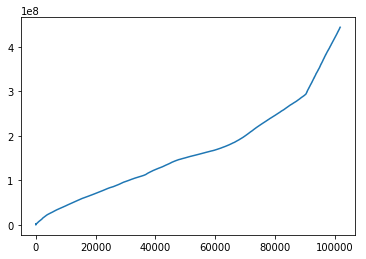

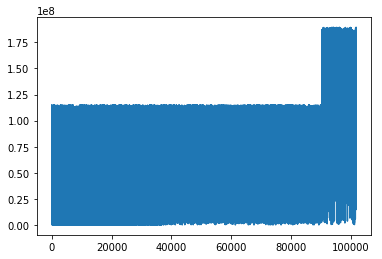

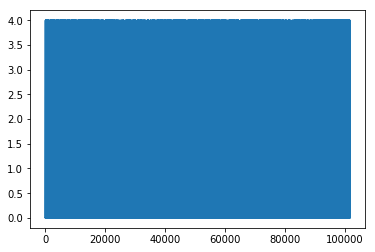

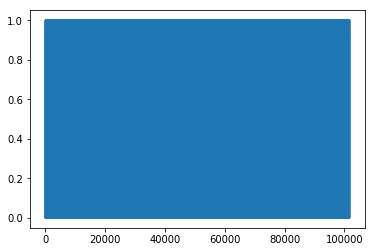

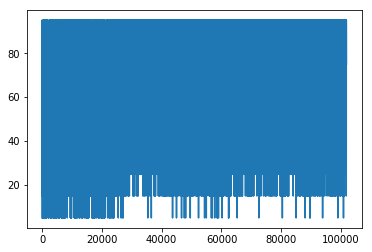

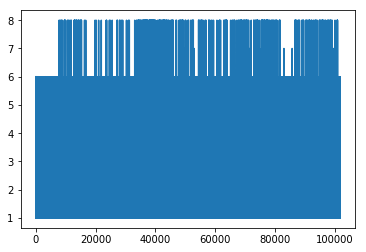

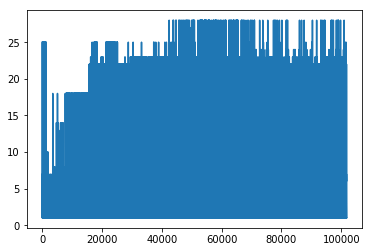

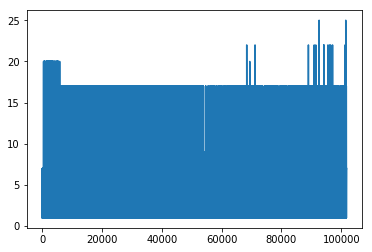

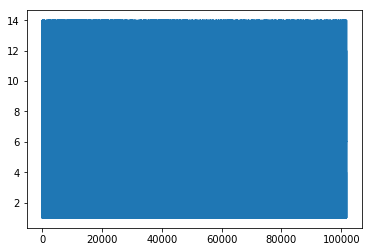

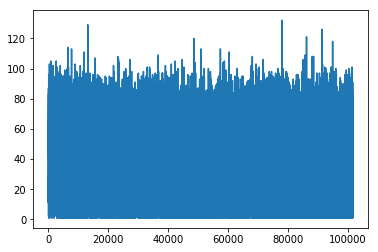

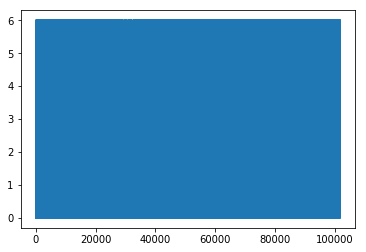

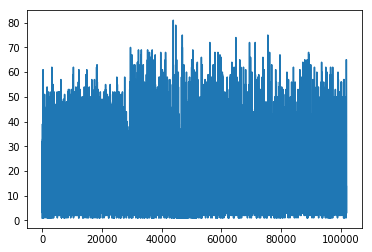

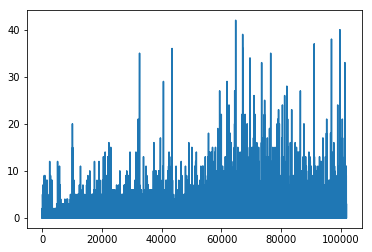

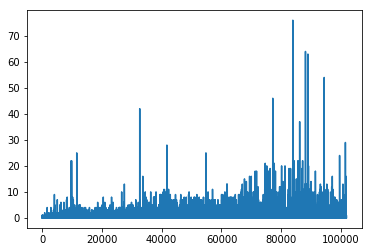

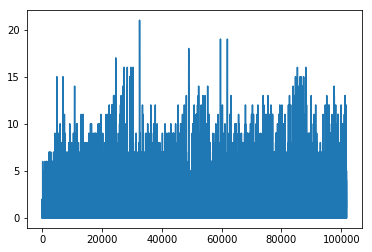

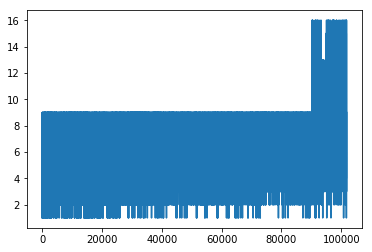

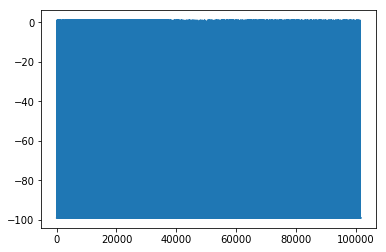

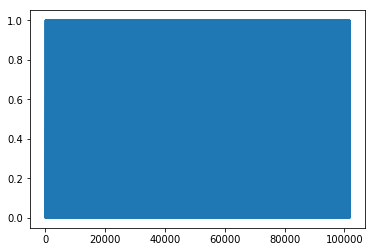

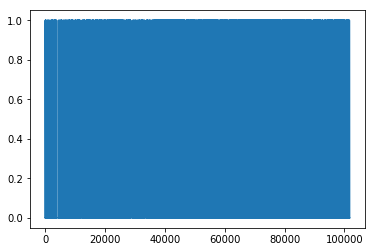

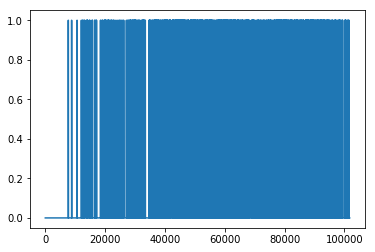

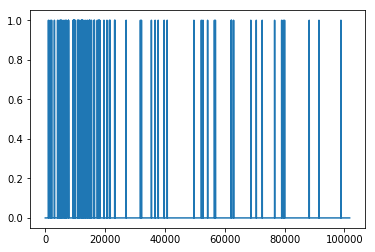

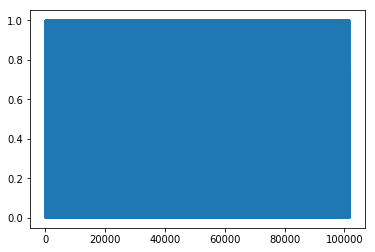

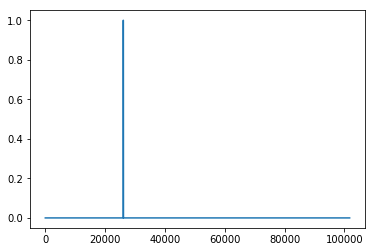

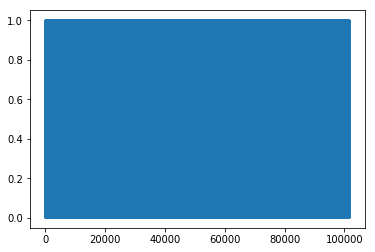

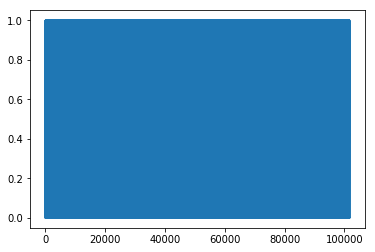

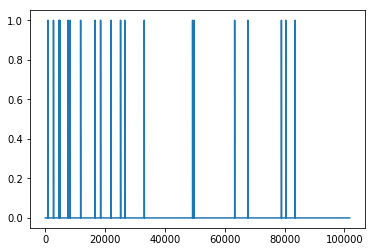

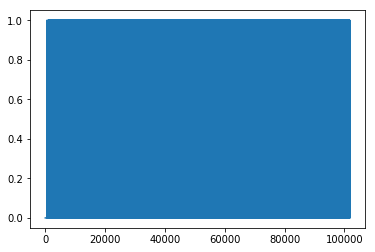

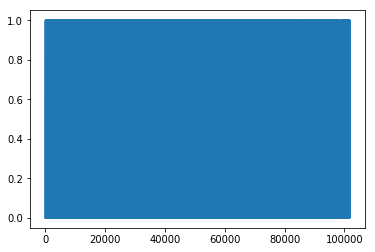

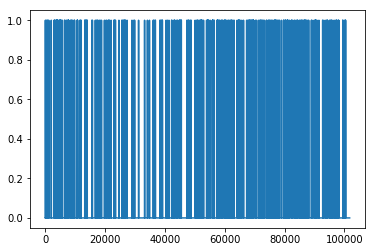

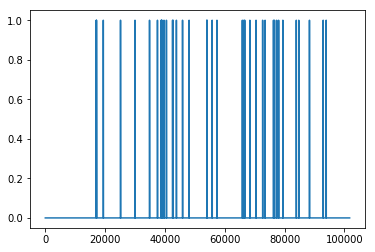

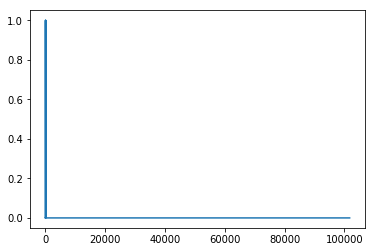

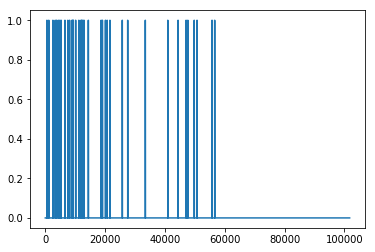

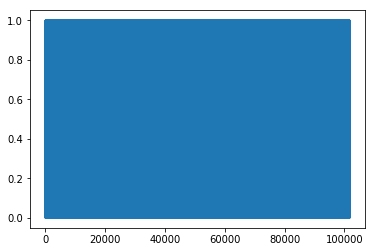

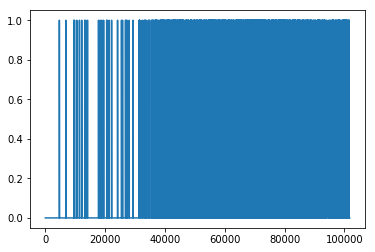

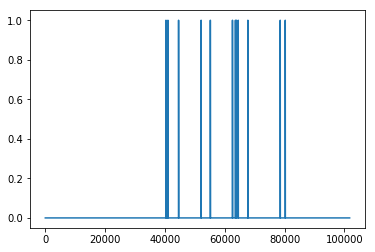

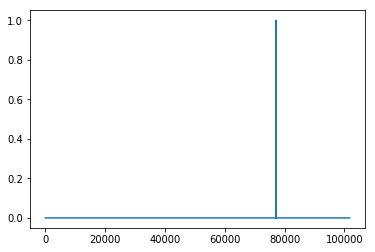

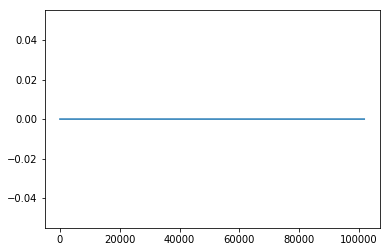

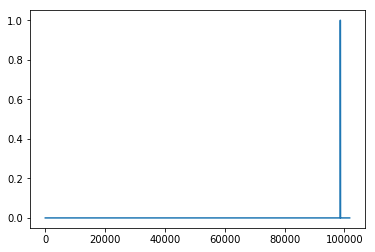

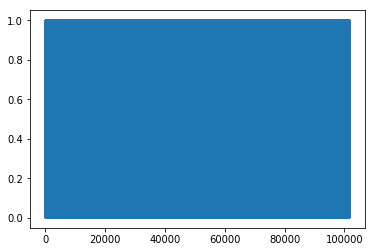

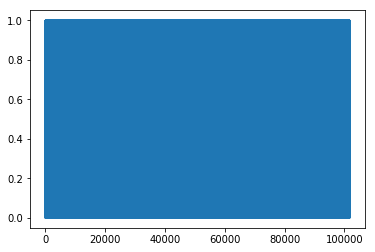

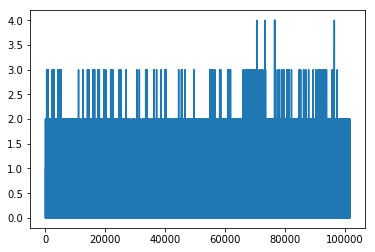

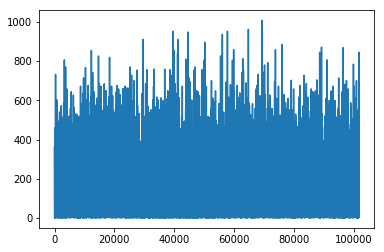

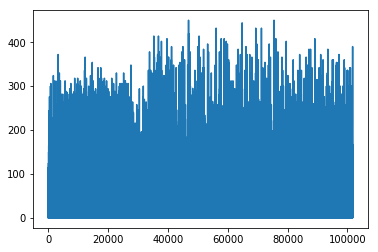

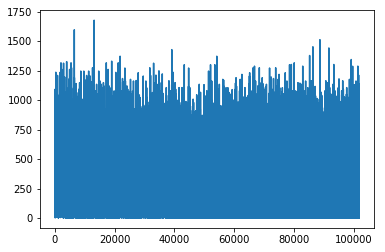

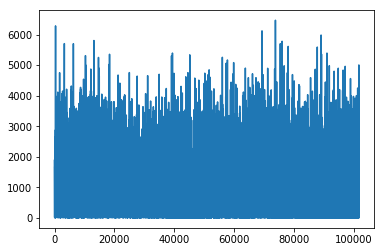

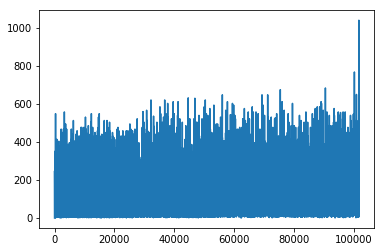

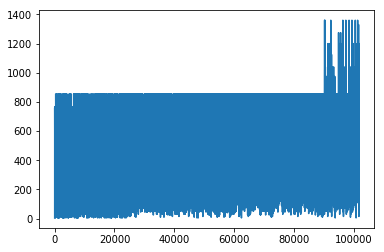

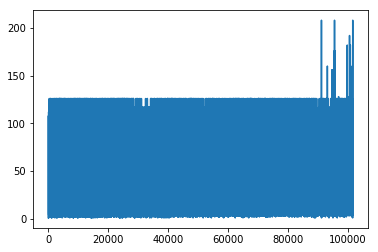

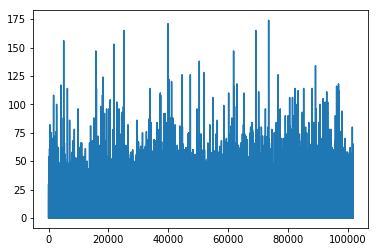

In [102]:
import matplotlib.pyplot as plt
for column in df.columns:
    plt.plot(df[column])
    plt.show()

In [103]:
import numpy as np
columns_to_drop = []
for column in df.columns:
    if np.count_nonzero(df[column]) < 1000:
        columns_to_drop.append(column)
print(columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

['nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


In [104]:
len(df)

97883

In [105]:
len(df.drop_duplicates('patient_nbr'))

68618

In [106]:
df = df.drop_duplicates('patient_nbr')

In [108]:
df.to_csv('data_cleaned3.csv')

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68618 entries, 0 to 101765
Data columns (total 36 columns):
encounter_id                           68618 non-null int64
patient_nbr                            68618 non-null int64
race                                   68618 non-null int64
gender                                 68618 non-null int64
age                                    68618 non-null int64
admission_type_id                      68618 non-null int64
discharge_disposition_id               68618 non-null int64
admission_source_id                    68618 non-null int64
time_in_hospital                       68618 non-null int64
num_lab_procedures                     68618 non-null int64
num_procedures                         68618 non-null int64
num_medications                        68618 non-null int64
number_outpatient                      68618 non-null int64
number_emergency                       68618 non-null int64
number_inpatient                       68618 non-n